# Payoff d'un strangle long sur SPY

Ce TP documente le payoff d'un strangle européen (put OTM + call OTM) sur SPY.
Objectifs pédagogiques :
1. Examiner l'historique de SPY sur un an pour fixer un spot de référence.
2. Définir les strikes d'un strangle (put plus bas, call plus haut) autour du spot.
3. Tracer la courbe de payoff en fonction du spot et relier la formule à la visualisation.

In [65]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import sys
from pathlib import Path

scripts_candidates = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]
for base in scripts_candidates:
    candidate = base / "notebooks" / "scripts"
    if candidate.exists():
        sys.path.insert(0, str(candidate))
        break
from pricing import payoff_call, payoff_put, payoff_strangle, price_strangle_bs

plt.style.use("seaborn-v0_8-darkgrid")

def fetch_spy_history(period="1y", interval="1d") -> pd.Series:
    """Récupère les prix SPY (cache local puis fallback yfinance)."""
    cache_path = Path("notebooks/GPT/_cache_spy_close.csv")
    if cache_path.exists():
        try:
            cached = pd.read_csv(cache_path, index_col=0, parse_dates=True)
            if not cached.empty and "Close" in cached.columns:
                return cached["Close"]
        except Exception:
            pass
    data = yf.download("SPY", period=period, interval=interval, progress=False)
    if data.empty or "Close" not in data:
        raise RuntimeError("Impossible de récupérer les prix SPY")
    close = data["Close"]
    try:
        cache_path.parent.mkdir(parents=True, exist_ok=True)
        close.to_csv(cache_path, index_label="date")
    except Exception:
        pass
    return close

# Récupération des prix de clôture (dernier close pour spot_ref)
close_spy = fetch_spy_history()
spot_ref = float(close_spy.iloc[-1])


k_put = spot_ref * 0.95
k_call = spot_ref * 1.05


C:\Users\nicol\AppData\Local\Temp\ipykernel_19504\1068373964.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", period=period, interval=interval, progress=False)
C:\Users\nicol\AppData\Local\Temp\ipykernel_19504\1068373964.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spot_ref = float(close_spy.iloc[-1])


## Évolution du sous-jacent (SPY)
Historique des clôtures sur un an et repère du spot de référence (dernier close).

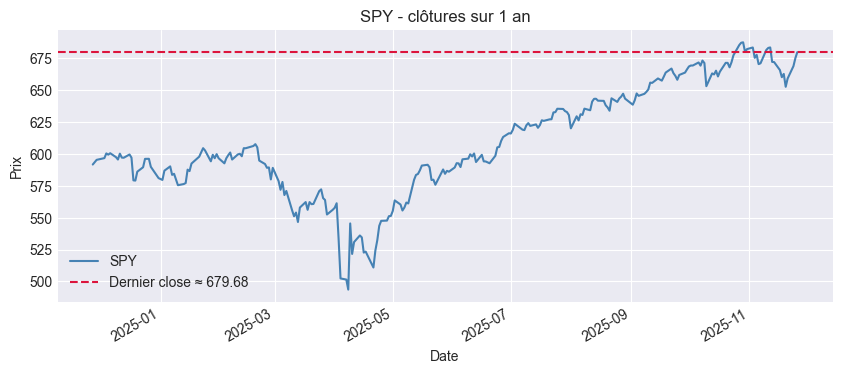

In [66]:
fig, ax = plt.subplots(figsize=(10, 4))
close_spy.plot(ax=ax, color="steelblue", label="SPY close")
ax.axhline(spot_ref, color="crimson", linestyle="--", label=f"Dernier close ≈ {spot_ref:.2f}")
ax.set_title("SPY - clôtures sur 1 an")
ax.set_xlabel("Date")
ax.set_ylabel("Prix")
ax.legend()
plt.show()

## Payoff du strangle long
Le payoff est la somme d'un put strike bas (OTM) et d'un call strike haut (OTM). La zone centrale perd la prime, tandis que les ailes captent une convexité plus prononcée qu'un straddle.

## Payoff interactif
Utilise les curseurs ci-dessous pour visualiser le payoff en fonction de S_0, S_T, K put et K call.


In [67]:

import ipywidgets as widgets
from IPython.display import display, Markdown
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Ajout des chemins possibles (notebooks/GPT, notebooks, racine)
_base = Path.cwd().resolve()
for extra in (_base, _base.parent, _base.parent.parent):
    if str(extra) not in sys.path:
        sys.path.append(str(extra))
from streamlit_appGPT import compute_option_payoff

spot0_slider = widgets.FloatSlider(value=spot_ref, min=spot_ref*0.5, max=spot_ref*1.5, step=1.0, description='S_0')
spotT_slider = widgets.FloatSlider(value=spot_ref, min=spot_ref*0.5, max=spot_ref*1.5, step=1.0, description='S_T')
slider_put = widgets.FloatSlider(value=spot_ref*0.95, min=spot_ref*0.5, max=spot_ref*1.2, step=1.0, description='K put')
slider_call = widgets.FloatSlider(value=spot_ref*1.05, min=spot_ref*0.8, max=spot_ref*1.5, step=1.0, description='K call')
output = widgets.Output()


def _price_strangle_via_ui(s: float, k_put: float, k_call: float) -> float:
    put_entry = {"option_type": "put", "product_type": "vanilla", "strike": k_put, "side": "long", "quantity": 1}
    call_entry = {"option_type": "call", "product_type": "vanilla", "strike": k_call, "side": "long", "quantity": 1}
    return compute_option_payoff(put_entry, s) + compute_option_payoff(call_entry, s)


def _update_payoff(change=None):
    with output:
        output.clear_output()
        s0 = spot0_slider.value
        sT = spotT_slider.value
        k_put = slider_put.value
        k_call = slider_call.value
        if k_put >= k_call or k_put >= s0 or k_call <= s0:
            display(Markdown("⚠️ Assure-toi que K_put < S_0 < K_call."))
            return
        payoff_T = payoff_strangle(sT, k_put, k_call)
        intrinsic_price = payoff_strangle(s0, k_put, k_call)
        price_ui = _price_strangle_via_ui(s0, k_put, k_call)

        s_grid = np.linspace(s0 * 0.5, s0 * 1.5, 200)
        payoffs = [payoff_strangle(s, k_put, k_call) for s in s_grid]

        fig, ax = plt.subplots(figsize=(7, 4))
        ax.plot(s_grid, payoffs, label='Payoff strangle')
        ax.axvline(k_put, color='gray', linestyle=':', label=f'K put = {k_put:.2f}')
        ax.axvline(k_call, color='gray', linestyle='--', label=f'K call = {k_call:.2f}')
        ax.axvline(s0, color='crimson', linestyle='-.', label=f'S_0 = {s0:.2f}')
        ax.scatter([sT], [payoff_T], color='gold', zorder=5, label=f'S_T payoff = {payoff_T:.2f}')
        ax.set_xlabel('Spot')
        ax.set_ylabel('Payoff')
        ax.legend(loc='lower right')
        ax.set_title('Payoff strangle en fonction du spot')
        plt.show()

        display(Markdown(
            f"""**S_0 = {s0:.2f}**, **S_T = {sT:.2f}**

- K put = {k_put:.2f}
- K call = {k_call:.2f}
- Prix (compute_option_payoff @ S_0) = {price_ui:.4f}
- Valeur (intrinsèque) au spot S_0 ≈ {intrinsic_price:.4f}
- Payoff à l'expiration = {payoff_T:.4f}"""
        ))

for sl in (spot0_slider, spotT_slider, slider_put, slider_call):
    sl.observe(_update_payoff, names='value')

_update_payoff()
display(widgets.VBox([spot0_slider, spotT_slider, slider_put, slider_call, output]))
